In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import time
from sklearn.metrics import mean_squared_error

'''
None || 20000 || 100000
'''
nb = None
nb_trains = nb
nb_valids = nb
nb_tests = nb

N_past = 10

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd drive/MyDrive/Projects/JPX_Tokyo_Stock/working


/content/drive/MyDrive/Projects/JPX_Tokyo_Stock/working


In [4]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 14.5 MB/s 
     |████████████████████████████████| 81 kB 12.4 MB/s 
     |████████████████████████████████| 209 kB 84.1 MB/s 
     |████████████████████████████████| 78 kB 9.7 MB/s 
     |████████████████████████████████| 49 kB 8.3 MB/s 
     |████████████████████████████████| 146 kB 83.7 MB/s 
     |████████████████████████████████| 112 kB 81.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=a6e2ab219de97ba89a795d48672918bda15d8f955495ea460d574ab4db729847
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [5]:
import optuna
from data_utils import *

#### Load Data

In [6]:
train_df = pd.read_csv('../input/3_after_feature_selection/' + str(N_past) + '/train_full.csv', parse_dates=['Date'], nrows = nb_trains)
valid_df = pd.read_csv('../input/3_after_feature_selection/' + str(N_past) + '/valid_full.csv', parse_dates=['Date'], nrows = nb_valids)
test_df = pd.read_csv('../input/3_after_feature_selection/' + str(N_past) + '/test_full.csv', parse_dates=['Date'], nrows = nb_tests)
y_test_df = pd.read_csv('../input/3_after_feature_selection/' + str(N_past) + '/y_test_full.csv', parse_dates=['Date'], nrows = nb_tests)

official_test_df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv', nrows = None, parse_dates=['Date'])

In [7]:
mini_train_after_dataPreprocessing = pd.read_csv('../input/1_after_datapreprocessing/mini_train.csv', parse_dates=['Date'], nrows = None)
mini_train_after_featureEngineering = pd.read_csv('../input/2_after_featureEgineering/' + str(N_past) + '/mini_train.csv', parse_dates=['Date'], nrows = None)

In [8]:
official_test_df = FeatureEgineering_for_official_test(DataPreprocessing_for_official_test(official_test_df, mini_train_after_dataPreprocessing), mini_train_after_featureEngineering, N_past)

/content/drive/MyDrive/Projects/JPX_Tokyo_Stock/working/data_utils.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return['ExpectedDividend'] = df_return['ExpectedDividend'].fillna(-1)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4573509 entries, 0 to 4573508
Data columns (total 34 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Date                datetime64[ns]
 1   ExpectedDividend    float64       
 2   Year                int64         
 3   dayofyear           int64         
 4   is_month_start      bool          
 5   Day                 int64         
 6   dayofweek           int64         
 7   Volume              float64       
 8   Close_std           float64       
 9   Close_mean          float64       
 10  Close               float64       
 11  is_month_end        bool          
 12  Volume_1_before     float64       
 13  Volume_10_before    float64       
 14  Close_10_before     float64       
 15  SecuritiesCode      int64         
 16  Range_HL_10_before  float64       
 17  Range_HL_8_before   float64       
 18  Range_HL_9_before   float64       
 19  Close_8_before      float64       
 20  Cl

In [10]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233223 entries, 0 to 233222
Data columns (total 34 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                233223 non-null  datetime64[ns]
 1   ExpectedDividend    233223 non-null  float64       
 2   Year                233223 non-null  int64         
 3   dayofyear           233223 non-null  int64         
 4   is_month_start      233223 non-null  bool          
 5   Day                 233223 non-null  int64         
 6   dayofweek           233223 non-null  int64         
 7   Volume              233223 non-null  float64       
 8   Close_std           233223 non-null  float64       
 9   Close_mean          233223 non-null  float64       
 10  Close               233223 non-null  float64       
 11  is_month_end        233223 non-null  bool          
 12  Volume_1_before     233223 non-null  float64       
 13  Volume_10_before    233223 no

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229952 entries, 0 to 229951
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                229952 non-null  datetime64[ns]
 1   ExpectedDividend    229952 non-null  float64       
 2   Year                229952 non-null  int64         
 3   dayofyear           229952 non-null  int64         
 4   is_month_start      229952 non-null  bool          
 5   Day                 229952 non-null  int64         
 6   dayofweek           229952 non-null  int64         
 7   Volume              229952 non-null  float64       
 8   Close_std           229952 non-null  float64       
 9   Close_mean          229952 non-null  float64       
 10  Close               229952 non-null  float64       
 11  is_month_end        229952 non-null  bool          
 12  Volume_1_before     229952 non-null  float64       
 13  Volume_10_before    229952 no

In [12]:
y_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229952 entries, 0 to 229951
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   SecuritiesCode  229952 non-null  int64         
 1   Date            229952 non-null  datetime64[ns]
 2   CloseT1         229952 non-null  float64       
 3   CloseT2         229952 non-null  float64       
 4   Target          229952 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 8.8 MB


In [13]:
official_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                4000 non-null   datetime64[ns]
 1   SecuritiesCode      4000 non-null   int64         
 2   Volume              4000 non-null   float64       
 3   AdjustmentFactor    4000 non-null   float64       
 4   ExpectedDividend    4000 non-null   float64       
 5   SupervisionFlag     4000 non-null   bool          
 6   Close               4000 non-null   float64       
 7   Range_HL            4000 non-null   float64       
 8   Range_OC            4000 non-null   float64       
 9   dayofyear           4000 non-null   int64         
 10  dayofweek           4000 non-null   int64         
 11  week                4000 non-null   UInt32        
 12  is_month_end        4000 non-null   bool          
 13  is_month_start      4000 non-null   bool        

### Calc Scores

In [14]:
def calc_spread_return_per_day(df, portfolio_size: int = 200, toprank_weight_ratio: float = 2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

def add_rank(df: pd.DataFrame, y_pred):
    df["Pred"] = y_pred
    df["Rank"] = df.groupby("Date")["Pred"].rank(ascending=False, method="first") - 1 
    df = df.drop("Pred", axis= 1)
    return df

In [15]:
def calc_score(df: pd.DataFrame, y_pred: pd.DataFrame, y_true: pd.DataFrame, render_info= True):
    feature_df = df.copy()
    feature_df = add_rank(feature_df, y_pred)
    feature_df['Target'] = y_true
    score, buf = calc_spread_return_sharpe(feature_df)
    if render_info:
        print(f'score -> {score}\nmean -> {buf.mean()}\nstd -> {buf.std()}')
    del feature_df
    return score

In [17]:
calc_score(test_df, y_test_df["Target"], y_test_df["Target"])

score -> 4.687380919991682
mean -> 15.446241603409499
std -> 3.2952819211963917


4.687380919991682

### Cross Validation

In [18]:
featureCols = train_df.drop(["Target", "CloseT1", "CloseT2"], axis = 1).columns
featureCols

Index(['Date', 'ExpectedDividend', 'Year', 'dayofyear', 'is_month_start',
       'Day', 'dayofweek', 'Volume', 'Close_std', 'Close_mean', 'Close',
       'is_month_end', 'Volume_1_before', 'Volume_10_before',
       'Close_10_before', 'SecuritiesCode', 'Range_HL_10_before',
       'Range_HL_8_before', 'Range_HL_9_before', 'Close_8_before',
       'Close_9_before', 'Close_4_before', 'Close_1_before', 'Close_2_before',
       'Range_HL_2_before', 'Close_6_before', 'Close_7_before', 'Range_OC',
       'Range_HL_4_before', 'Range_OC_2_before', 'Range_OC_1_before'],
      dtype='object')

In [19]:
X_train = train_df[featureCols]
X_train["Date"] = X_train["Date"].astype(str)
y_train = train_df["Target"]

X_valid = valid_df[featureCols]
X_valid["Date"] = X_valid["Date"].astype(str)
y_valid = valid_df["Target"]

X_test = test_df[featureCols]
X_test["Date"] = X_test["Date"].astype(str)
y_test = y_test_df["Target"]

del train_df, valid_df, y_test_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
calc_score(X_test, y_test, y_test)

score -> 4.687380919991682
mean -> 15.446241603409499
std -> 3.2952819211963917


4.687380919991682

#### Optuna tuning

In [22]:
x_train_optuna = X_train.drop("Date", axis = 1)
y_train_optuna = y_train
x_eval_optuna = X_valid
x_eval_not_date = X_valid.drop("Date", axis = 1)
y_eval_optuna = y_valid

In [23]:
def objective(
    trial,
    random_state=22,
    n_jobs=-1,
):
    # XGBoost parameters
    params = {
        'tree_method':'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": 1000,
        "max_depth": trial.suggest_int("max_depth", 11, 25),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.6, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "seed": random_state,
        "n_jobs": n_jobs,
        "early_stopping_rounds": 50,
        "eval_metric": "rmse"
        
    }

    model = xgb.XGBRegressor(**params) 

    model.fit(
        x_train_optuna,
        y_train_optuna,
        eval_set=[(x_eval_not_date, y_eval_optuna)],
        verbose=0,
    )
    y_pred = pd.DataFrame(model.predict(x_eval_not_date), columns =['Target'])
    del model
    time.sleep(10)
    return calc_score(x_eval_optuna, y_pred, y_eval_optuna, render_info= False)

In [24]:
1/0

ZeroDivisionError: ignored

In [46]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, gc_after_trial=True)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-06-20 18:28:12,378] A new study created in memory with name: no-name-3dec54c1-7ed3-420e-a56d-48857618534c
[I 2022-06-20 18:32:55,384] Trial 0 finished with value: 0.41433363186296684 and parameters: {'max_depth': 22, 'learning_rate': 0.027824977305582244, 'colsample_bytree': 0.5811275613271997, 'subsample': 0.6214364140440178, 'alpha': 0.014948675484928299, 'lambda': 0.012001196166477495, 'min_child_weight': 863.5616331507786}. Best is trial 0 with value: 0.41433363186296684.
[I 2022-06-20 18:36:09,126] Trial 1 finished with value: 0.3173967086480381 and parameters: {'max_depth': 12, 'learning_rate': 0.007079848766654107, 'colsample_bytree': 0.29277745556264967, 'subsample': 0.712320454410297, 'alpha': 3.44090094218252, 'lambda': 1.895257824234372, 'min_child_weight': 34.89513162466498}. Best is trial 0 with value: 0.41433363186296684.
[I 2022-06-20 18:46:45,117] Trial 2 finished with value: 0.4172333331817561 and parameters: {'max_depth': 24, 'learning_rate': 0.010807510852408

Number of finished trials: 30
Best trial: {'max_depth': 25, 'learning_rate': 0.019634328045568687, 'colsample_bytree': 0.4120999486738328, 'subsample': 0.6589236310677171, 'alpha': 0.012129282194610628, 'lambda': 0.01034942022644811, 'min_child_weight': 277.022934321288}
CPU times: user 3h 51min 37s, sys: 1min 2s, total: 3h 52min 40s
Wall time: 3h 57min 4s


In [47]:
best_params = {
  'max_depth': 25, 
  'learning_rate': 0.019634328045568687, 
  'colsample_bytree': 0.4120999486738328, 
  'subsample': 0.6589236310677171, 
  'alpha': 0.012129282194610628, 
  'lambda': 0.01034942022644811, 
  'min_child_weight': 277.022934321288,
 'early_stopping_rounds': 50,
 'eval_metric': 'rmse',
 'n_estimators': 1000,
 'n_jobs': -1,
 'objective': 'reg:squarederror',
 'seed': 22,
 'tree_method': 'gpu_hist',
 'verbosity': 0}

best_params

{'alpha': 0.03924390034293432,
 'colsample_bytree': 0.49131299401745826,
 'early_stopping_rounds': 50,
 'eval_metric': 'rmse',
 'lambda': 0.039524775303420884,
 'learning_rate': 0.025393717408045614,
 'max_depth': 15,
 'min_child_weight': 309.2995037383647,
 'n_estimators': 1000,
 'n_jobs': -1,
 'objective': 'reg:squarederror',
 'seed': 22,
 'subsample': 0.6375116675619695,
 'tree_method': 'gpu_hist',
 'verbosity': 0}

In [48]:
best_params = study.best_trial.params
best_params['tree_method'] = 'gpu_hist'
best_params['verbosity'] = 0
best_params['objective'] = "reg:squarederror"
best_params['n_estimators'] = 1000
best_params['seed'] = 22
best_params['n_jobs'] = -1
best_params["early_stopping_rounds"] = 50
best_params["eval_metric"] = "rmse"

best_params

{'alpha': 0.012129282194610628,
 'colsample_bytree': 0.4120999486738328,
 'early_stopping_rounds': 50,
 'eval_metric': 'rmse',
 'lambda': 0.01034942022644811,
 'learning_rate': 0.019634328045568687,
 'max_depth': 25,
 'min_child_weight': 277.022934321288,
 'n_estimators': 1000,
 'n_jobs': -1,
 'objective': 'reg:squarederror',
 'seed': 22,
 'subsample': 0.6589236310677171,
 'tree_method': 'gpu_hist',
 'verbosity': 0}

In [49]:
%%time
model = xgb.XGBRegressor(**best_params) 

model.fit(
    X_train.drop("Date", axis = 1),
    y_train,
    eval_set=[(X_valid.drop("Date", axis = 1), y_valid)],
    verbose=0,
)

CPU times: user 12min 8s, sys: 2.34 s, total: 12min 10s
Wall time: 12min 7s


In [50]:
%%time
y_pred = pd.DataFrame(model.predict(X_train.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_train, y_pred, y_train, render_info= False))

4.356871046238159
CPU times: user 23.2 s, sys: 3.11 s, total: 26.3 s
Wall time: 26.1 s


In [51]:
np.sqrt(mean_squared_error(y_pred, y_train))

0.021184488174240727

In [52]:
%%time
y_pred = pd.DataFrame(model.predict(X_valid.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_valid, y_pred, y_valid, render_info= False))

0.447276416607291
CPU times: user 1.37 s, sys: 87 ms, total: 1.46 s
Wall time: 1.43 s


In [53]:
np.sqrt(mean_squared_error(y_pred, y_valid))

0.028117557544849636

In [54]:
%%time
y_pred = pd.DataFrame(model.predict(X_test.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_test, y_pred, y_test, render_info= False))

0.20118212322632043
CPU times: user 1.25 s, sys: 95.1 ms, total: 1.34 s
Wall time: 1.33 s


In [55]:
np.sqrt(mean_squared_error(y_pred, y_test))

0.024731751777029173

In [56]:
def render_feature_important(model_xgboost, df_trained):
  feature_important = model.feature_importances_
  sorted_idx = np.argsort(feature_important)[::-1]

  keys = df_trained.columns[sorted_idx]
  values = feature_important[sorted_idx]

  data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
  data.plot(kind='barh', figsize = (20,10))

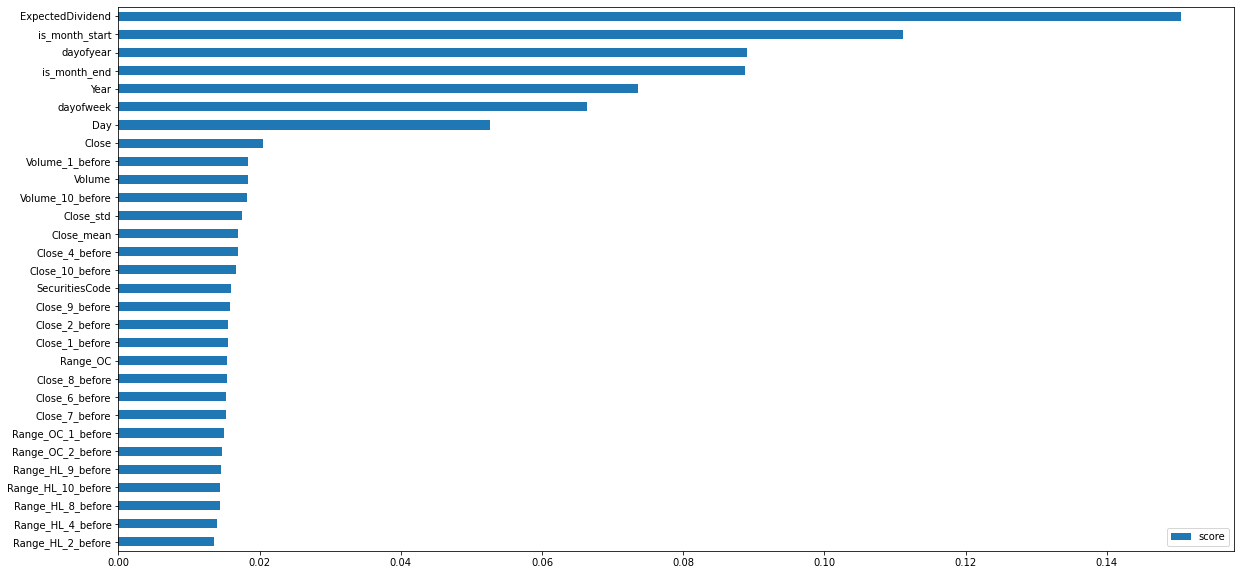

In [57]:
render_feature_important(model, X_train.drop("Date", axis = 1))

#### test pred official_test

In [63]:
official_test_df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv', nrows = None, parse_dates=['Date'])
mini_train_after_dataPreprocessing = pd.read_csv('../input/1_after_datapreprocessing/mini_train.csv', parse_dates=['Date'], nrows = None)

In [64]:
official_test_df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
3995,20211207_9990,2021-12-07,9990,526.0,535.0,524.0,535.0,57800,1.0,NaN,False
3996,20211207_9991,2021-12-07,9991,795.0,806.0,792.0,805.0,48500,1.0,NaN,False
3997,20211207_9993,2021-12-07,9993,1640.0,1640.0,1620.0,1620.0,6600,1.0,NaN,False
3998,20211207_9994,2021-12-07,9994,2437.0,2440.0,2423.0,2440.0,5200,1.0,NaN,False


In [65]:
y_test_official = DataPreprocessing_for_official_test(official_test_df, mini_train_after_dataPreprocessing)
y_test_official

/content/drive/MyDrive/Projects/JPX_Tokyo_Stock/working/data_utils.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return['ExpectedDividend'] = df_return['ExpectedDividend'].fillna(-1)


,Date,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Open,High,Low,Close
0,2021-12-06,1301,8900,1.0,-1.0,False,2982.0,2982.0,2965.0,2971.0
1,2021-12-06,1332,1360800,1.0,-1.0,False,592.0,599.0,588.0,589.0
2,2021-12-06,1333,125900,1.0,-1.0,False,2368.0,2388.0,2360.0,2377.0
3,2021-12-06,1375,81100,1.0,-1.0,False,1230.0,1239.0,1224.0,1224.0
4,2021-12-06,1376,6200,1.0,-1.0,False,1339.0,1372.0,1339.0,1351.0
...,...,...,...,...,...,...,...,...,...,...
3995,2021-12-07,9990,57800,1.0,-1.0,False,526.0,535.0,524.0,535.0
3996,2021-12-07,9991,48500,1.0,-1.0,False,795.0,806.0,792.0,805.0
3997,2021-12-07,9993,6600,1.0,-1.0,False,1640.0,1640.0,1620.0,1620.0
3998,2021-12-07,9994,5200,1.0,-1.0,False,2437.0,2440.0,2423.0,2440.0
